### Pricing American Options with Montecarlo ###

# Part 4 - Longstaff and Schwartz Method #

In [1]:
%matplotlib inline

import numpy             as np
import matplotlib.pyplot as plt
# local module
from gdl_finance.analytic import BlackScholes

### Overview

- [Introduction](#Introduction)
- [The Idea](#The-Idea)
    - [Simple Polynomial Interpolation](#Simple-Polynomial-Interpolation)
- [Least Squares Montecarlo](#Least-Squares-Montecarlo)
    - [Approximate Continuation Value](#Approximate-Continuation-Value)
    - [Regression Based Pricing Algorithm](#Regression-Based-Pricing-Algorithm)
    - [A Simple Python Implementation of LSM](#A-Simple-Python-Implementation-of-LSM)
- [References](#References)    

## Introduction##

The Longstaff-Schwartz algorithm is one of the most popular among practitioners, particularly for the pricing of American options on more than one underlying asset. First of all we will present the general idea behind the method through a simple bermudian option pricing example, then we'll give a more formal presentation.

## The Idea ##

As we have seen Monte Carlo simulation is a flexible and powerful numerical method to value financial derivatives of any kind. However being a forward evolving technique, it is per se not suited to address the valuation of American or Bermudan options which are valued in general by backwards induction. Longstaff and Schwartz provide a numerically efficient method to resolve this problem by what they call Least-Squares Monte Carlo. 

As you know, the problem with Monte Carlo is that the decision to exercise an American option or not is dependent on the continuation value. Consider a simulation with $M + 1$ points in time and $I$ paths. Given a simulated index level $S_{t,i} , t\in \{0, ..., T \}, i \in \{1, ..., I \}$, what is the continuation value $C_{t,i}(S_{t,i})$, i.e. the expected payoff of not exercising the option? The approach of Longstaff-Schwartz approximates continuation values for American options in the backwards steps by an ordinary least-squares regression. 

Equipped with such approximations, the option is exercised if the approximate continuation value is lower than the value of immediate exercise. Otherwise it is not exercised.

In order to explain the metodology, let's start from a simpler problem. Consider a *bermudan option* which is similar to an american option, except that it can be early exercised once only on a specific set of dates. In the figure, we can represent the schedule of a put bermudan option with strike $K$ and maturity in $6$ years. Each year you can choose whether to exercise or not.

<img src="img/lesson_5/bermudan_exercise_1.png" alt="Bermudan Exercise Periods" width="50%" align="center" border="1">

Let's consider a simpler example: a put option which can be exercised early only once:

<img src="img/lesson_5/bermudan_exercise_2.png" alt="Bermudan Exercise Periods" width="50%" align="center" border="1">

Can we price this product by means of a Monte Carlo? Yes we can! Let's see how.

Let's implement a MC which actually simulates, besides the evolution of the market, what an investor holding this option would do (clearly an investor who lives in the risk neutral world). In the following example we will assume the following data, $S(T)=$, $K=$, $r=$, $\sigma=$, $t_1=1y$, $T=2y$.

We simulate that 1y has passed, computing the new value of the asset and the new value of the money market account

$$S(t_1 = 1y) = S(t_0)e^{(r-\frac{1}{2}\sigma^2 )(t_1-t_0) + \sigma \sqrt{t_1-t_0}N(0,1)}$$

$$B(t_1 = 1y) = B(t_0) e^{r(t_1-t_0)}$$

At this point the investor could exercise. How does he know if it is convenient? In case of exercise he knows exactly the payoff he's getting. In case he continues, he knows that it is the same of having a European Put Option.

So, in mathematical terms we have the following payoff in $t_1$

$$\max \left[
K-S(t_1), P(t_1,T;S(t_1),K)
\right] $$

Where $P(t_1,T;S(t_1),K)$ is the price of a Put which we compute analytically! In the jargon of american products, $P$ is called the continuation value, i.e. the value of holding the option instead of early exercising it.

So the premium of the option is the average of this discounted payoff calculated in each iteration of the Monte Carlo procedure.

$$
\frac{1}{N} \sum\limits_i
\max \left[
K-S_i(t_1), P(t_1,T;S_i(t_1),K)
\right] $$

Some considerations are in order. We could have priced this product because we have an analytical pricing formula for the put. What if we didn't have it? 

Brute force solution: for each realization of $S(t_1)$ we run another Monte Carlo to price the put. This method (called Nested Monte Carlo) is very time consuming. For this very simple case it's time of execution grows as $N^2$, which becomes prohibitive when you deal with more than one exercise date!

Let's search for a finer solution analyzing the relationship between the continuation value (in this very simple example) and the simulated realization of $S$ at step $t_1$. 

In [2]:
# Model Parameters
S0     =  90.0   # initial stock level
K      = 100.0   # strike price
T      =   1.0   # time-to-maturity
r      =   0.00  # short rate
sigma  =   0.20  # volatility
delta  =   0.0   # dividend yield
payout =  -1

# Simulation Parameters
b = 10000   # number of paths
M = 3      # number of points for each path
dt = float(T) / float(M)
df = np.exp(-r * dt)
#
# Random numbers generations. We use the function 'randn' which returns 
# a sample (or samples) from the "standard normal" distribution.
# If positive, int_like or int-convertible arguments are provided,
# 'randn' generates an array of shape (d0, d1, ..., dn), filled
# with random floats sampled from a univariate "normal" (Gaussian)
# distribution of mean 0 and variance 1
#
z1  = np.random.randn(M + 1, b)
#
# Stock Price Paths. The function 'cumsum' returns the cumulative sum 
# of the elements along a given axis, in this case we want to sum along
# the time axis (axis=0)
#
S     = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt 
       + sigma * np.sqrt(dt) * z1, axis=0))
S[0]  = S0


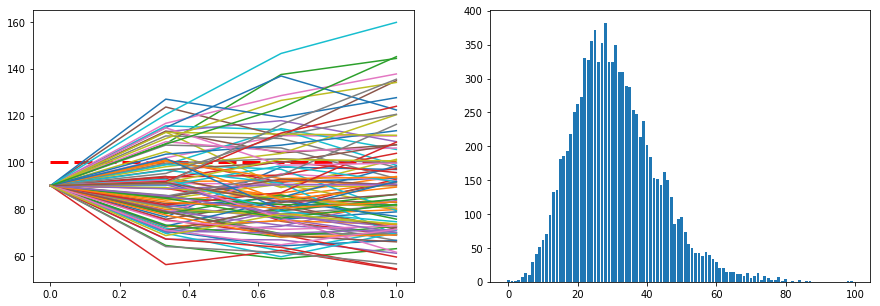

In [3]:
# plotting the first 100 paths
t = np.linspace(0, T, M+1)
paths = S[:,1:100]
#
# plotting expiry price distribution. Note that the S matrix is build 
# with the first index running on the time slice and the second index
# running on the number of simulated path. Remember that Python programming 
# language supports negative indexing of arrays, something which is not 
# available in arrays in most other programming languages. This means that 
# the index value of -1 gives the last element, and -2 gives the second 
# last element of an array. The negative indexing starts from where the 
# array ends. So in this case we are selecting all the simulated value 
# (second index = ':') of the last simulated time (first index = '-1').
#
expiry = S[-1,:]
hist = np.histogram(expiry, 100)
index = np.arange(100)

plt.figure(figsize=(15,5))
plt.subplot(121)

strike = np.array([K for n in range(0,M+1)])
plt.plot(t, strike, color='r', dashes=[6,2], linewidth=3.0)
plt.plot(t, paths)

plt.subplot(122)
plt.bar(index, hist[0])

plt.show()

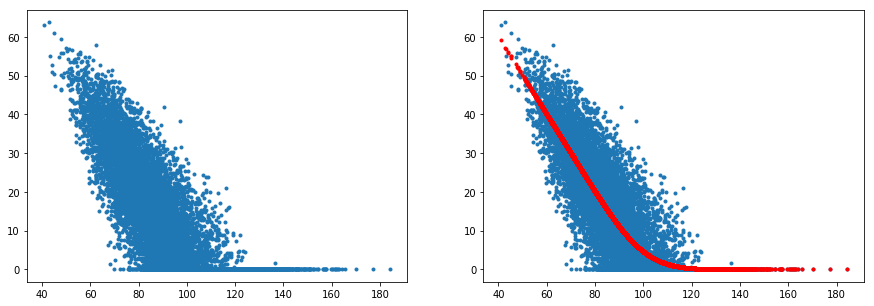

In [4]:
#
# Asset value at T-1
S2 = S[-2,:]
payoff = np.maximum(payout*(expiry-K),0)*np.exp(-r *2*dt)    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(S2, payoff,'.')

O = BlackScholes(payout, S2, K, r, delta, sigma, dt)

plt.subplot(122)
plt.plot(S2, payoff,'.')
plt.plot(S2, O,'.', color='r')
plt.show()

As you can see, the analytical price of the option is a curve which kinds of interpolate the cloud of Monte Carlo points. This suggest us that 

+ **the price at time $t_1$ can be computed by means of an average on all discounted payoff (i.e. the barycentre of the cloud made of discounted payoff)**

So maybe...

+ **the future value of an option can be seen as the problem of finding the curve that best fits the cloud of discounted payoff (up to date of interest)!!!**

Below, for example, there is a curve found by means of a linear regression on a polynomial of 5th order...

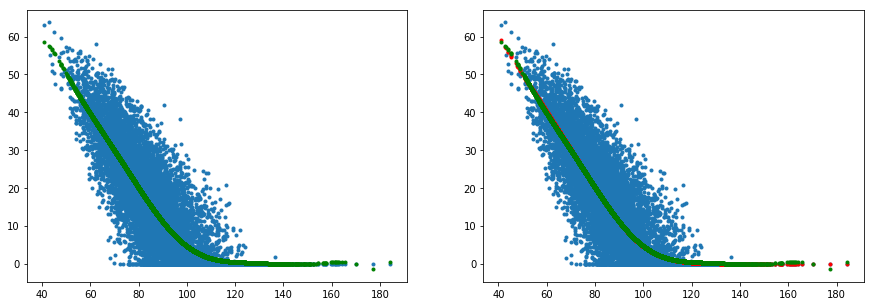

In [5]:
npol = 9
rg   = np.polyfit(S2, payoff, npol)
yy   = np.polyval(rg, S2)

plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(S2, payoff,'.')
plt.plot(S2, yy,'.',color='g') 

# And here we see both the curve overlapping (in green the 5th order polynomial and in 
# red the analytical solution of black and scholes model) ...

plt.subplot(122)

plt.plot(S2, payoff,'.')
plt.plot(S2, O, '.', color='r')
plt.plot(S2, yy,'.', color='g')    

We now have an empirical pricing formula for the put to be used in my MCS

$$P(t_1, T, S(t_1), K) = c_0 + c_1S(t_1) + c_2S(t_1)^2 + c_3S(t_1)^3 + c_4S(t_1)^4 + c_5S(t_1)^5$$

The formula is obviously fast, the cost of the algorithm being the best fit. Please note that we could have used any form for the curve (not only a plynomial). This method has the advantage that it can be solved as a linear regression, which is fast.

### Simple Polynomial Interpolation ###

In [6]:
#
# Valuation of American Options
# with Least-Squares Monte Carlo
# 
# American Put Option
#
# Simulation Parameters
I = 100000
M = 25
dt = T / M
df = np.exp(-r * dt)

# Stock Price Paths
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt
    + sigma * np.sqrt(dt) * np.random.standard_normal((M + 1, I)), axis=0))
S[0] = S0

# Inner Values
h = np.maximum(payout*(S - K), 0)    

# Present Value Vector (Initialization)
V = h[-1]

# American Option Valuation by Backwards Induction
for t in range(M - 1, 0, -1):
    rg = np.polyfit(S[t], V * df, 5)
    C  = np.polyval(rg, S[t])             # continuation values
    V  = np.where(h[t] > C, h[t], V * df) # exercise decision

V0 = df * np.sum(V) / I  # LSM estimator

print ("American option value %5.3f" % V0)

American option value 13.596


## Least Squares Montecarlo ##


### Approximate Continuation Value ###

Regression based methods posit an expression for  the continuation value of the form

\begin{equation}
    C_i(x) = \mathbb{E} \left[ V_{i+1} \left( X_{i+1} \right)  \vert X_i = x \right]= \sum\limits_{r=1}^M \beta_{ir} \psi_r(x)
\label{eqn:LSM_1}
\end{equation}

for some basis functions $\psi_r : \mathbb{R}^b \rightarrow \mathbb{R}^b$ and constants $\beta_{ir}\,, r = 1,\dots, M $. We may equivalently write

\begin{equation}
    C_i(x) = \mathbf{\bar \beta}_i^T \mathbf{\bar \psi}(x)
\label{eqn:LSM_2}
\end{equation}

Assuming a relation of the form $\eqref{eqn:LSM_1}$ holds and remembering that the general form  of the least square estimate (or estimator, in the context of a random sample), $\beta$ is given by

$$
\beta =(X^{T}X)^{-1}X^{T}{\boldsymbol {y}}
$$

we can write

\begin{equation}
\beta_i = 
\left( 
\mathbb{E} \left[ \psi\left(X_i\right) \psi\left(X_i\right)^T \right] 
\right)^{-1}
\mathbb{E} \left[ \psi\left(X_i\right) V_{i+1} \left( X_{i+1} \right)  \right] 
\equiv B_\psi^{-1} B_{\psi V}
\label{eqn:LSM_3}
\end{equation}

since we are working with a number $b$ of simulated path, we have to take the expectation values of the matrix products involved. This is why this method is called Least Squares Montecarlo.

The coefficients $\beta_{ir}$ could be estimated from observations of pairs $(X_{ij}, V_{i+1}(X_{i+1,j})) \, j=1,\dots,b$ each consisting of **the state at time $i$ and the corrisponding option value at time $i+1$**.  In practice the least-squares estimate of $\beta_i$ is given by 

\begin{equation}
\hat \beta_i = \hat B_\psi^{-1} \hat B_{\psi V}
\end{equation}

where $\hat B_\psi$ and $\hat B_{\psi V}$ are the sample counterparts of $B_\psi$ and $B_{\psi V}$. More explicitly 

\begin{equation}
\hat B_\psi = \frac{1}{b} \sum\limits_{j=1}^b \psi_q \left( X_{ij} \right)\psi_r \left( X_{ij} \right)
\end{equation}

and

\begin{equation}
\hat B_{\psi V} = \frac{1}{b} \sum\limits_{j=1}^b \psi_r \left( X_{ij} \right) V_{i+1}\left( X_{i+1,j} \right)
\end{equation}

this last formula reminds you of something?

All of these quantities can be calculated from function  values at pairs of consecutive nodes $\left( X_{ij}, X_{i+1,j} \right) \, j=1,\dots,b$. In practive $V_{i+1}$ is unknown and must be replaced by estimated values $\hat V_{i+1}$. The estimate $\hat \beta_i$ then defines an estimate 

\begin{equation}
\hat C_i(x) = \mathbf{\hat \beta}_i^T \mathbf{\psi}(x)
\label{eqn:LSM_4}
\end{equation}

of the continuation value at an arbitrary point $x$ in the state space $\mathbb{R}^b$.

### Regression Based Pricing Algorithm ###

- Simulate $b$ independent paths $\{ X_{1j},\dots,X_{mj}\}\, j= 1,\dots,b$ of the Markov chain ;
- For $t=T$ the option value is $\hat V_{mj} = h_m(X_{mj})\,j= 1,\dots,b $ by arbitrage
- Start iterating backwards: for $i=m-1,\dots,1$:
    - given estimated values $\hat V_{i+1,j}\, j= 1,\dots,b$, use regression as above to calculate $\hat \beta_i = \hat B_\psi^{-1} \hat B_{\psi V}$;
    - set 
    \begin{equation}
    \hat V_{ij} = \max \left[ h_i\left( X_{ij} \right), \hat C_{i} \left( X_{ij} \right) \right] \quad j= 1,\dots,b
    \label{eqn:LSM_5}
    \end{equation}
    with $\hat C_{i}$ given by $\eqref{eqn:LSM_4}$;
- Set $\hat V_0 = \left( \hat V_{11} + \dots + \hat V_{1b} \right)/b$


Longstaff and Scwhartz in their original paper followed a slightly different approach replacing $\eqref{eqn:LSM_5}$ with

\begin{equation}
\hat V_{ij}= 
\begin{cases}
h_i\left( X_{ij} \right) & \quad \text{if } h_i\left( X_{ij} \right) \ge   \hat C_i\left( X_{ij} \right) \quad \text{(exercise takes place)}\\
\hat V_{i+1,j}           & \quad \text{otherwise (no exercise takes place)}\\
\end{cases}
\end{equation}

### A Simple Python Implementation of LSM ###

In [7]:
# Simulation Parameters
b  = 100000                # number of mc simulations
t  = [0.,1./3.,2./3.,1.]   # exercise opportunities
dt = t[1]-t[0]
df = np.exp(-r * dt)

point_estimate  = 0
#
# ----- 1st exercise data -----------------------------------------------
#
z1  = np.random.randn(b)
#
S1 = S0 * np.exp((r - delta - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1)
#
# ----- 2nd exercise data -----------------------------------------------
#
z2  = np.random.randn(b)
#
S2 = S1 * np.exp((r - delta - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z2)

In [8]:
#
# Time t2 = T - 1
#
# As we have already seen at the penultimate exercise date, the continuation value
# is simply the Black and Scholes pricing for an european option expiring at T 
# with the same parameters of the american option.
#
cont_t2 = BlackScholes(payout, S2, K, r, delta, sigma, 1./3.)  
Vt2     = np.maximum(np.maximum(payout*(S2 - K), 0), cont_t2)

#### Choosing Basis Functions: 1 - Rasmussen (2005) ####

For this implementation we followed Rasmussen (2005) and used the following basis functions:

\begin{align}
&\psi_0(X) = K, \notag\\
&\psi_1(X) = X, \notag\\
&\psi_2(X) = BS(X,t), \notag\\
&\psi_3(X) = X \cdot BS(X,t)
\end{align}

where $K$ is the strike price, $X$ the current asset price and $B(X,t)$ is the Black and Scholes European option price for an option expiring at $T$ with the same parameters as the american option. For each path we build the corresponding set of basis function:

In [9]:
#
# Time t1 = T - 2
#
Yt1 = Vt2 * np.exp(-r*dt)
psi = np.zeros((b, 4))
for i in range(0, b):
    bs_price = BlackScholes(payout, S1[i], K, r, delta, sigma, 2./3.)
    psi[i,0] = K
    psi[i,1] = S1[i]
    psi[i,2] = bs_price
    psi[i,3] = S1[i] * bs_price

Using the array $Y$ which contains the estimation of the option at time step $t_1$ we can calculate beta parameter according to:

\begin{equation}
\hat \beta_i = \hat B_\psi^{-1} \hat B_{\psi V}
\notag
\end{equation}

where $\hat B_\psi$ and $\hat B_{\psi V}$ are the sample counterparts of $B_\psi$ and $B_{\psi V}$. More explicitly 

\begin{equation}
\hat B_\psi = \frac{1}{b} \sum\limits_{j=1}^b \psi_q \left( X_{ij} \right)\psi_r \left( X_{ij} \right) = \Psi^T \cdot \Psi
\notag
\end{equation}

and

\begin{equation}
\hat B_{\psi V} = \frac{1}{b} \sum\limits_{j=1}^b \psi_r \left( X_{ij} \right) V_{i+1}\left( X_{i+1,j} \right) =
\Psi^T \cdot V
\notag
\end{equation}

In [10]:
beta_psi    = np.linalg.inv(np.dot(psi.T, psi))
beta_psi_v  = np.dot(psi.T, Yt1)
beta        = np.dot(beta_psi, beta_psi_v)
cont_t1     = np.dot(psi, beta)

Finally we compute our estimator according to:

\begin{equation}
\hat V_{ij}= 
\begin{cases}
h_i\left( X_{ij} \right) & \quad \text{if } h_i\left( X_{ij} \right) \ge   \hat C_i\left( X_{ij} \right) \quad \text{(exercise takes place)}\\
\hat V_{i+1,j}           & \quad \text{otherwise (no exercise takes place)}\\
\end{cases}
\end{equation}

In [11]:
Vt1 = Vt2 * np.exp(-r*dt)
for i in range(0,b):
    if max(payout*(S1[i]-K),0) >= cont_t1[i]:
        Vt1[i] = max(payout*(S1[i]-K),0)

In [12]:
Vt0 = Vt1 * np.exp(-r*dt)        
    
point_estimate = np.average(Vt0)     

In [13]:
print('branching        = ' + str(b))
print('point estimator  = ' + str("%.3f" % point_estimate))

branching        = 100000
point estimator  = 13.553


#### Choosing Basis Functions: 2 - Longstaff and Schwartz (2001) ####

Longstaff and Schwartz (2001) suggested to use as basis function the Laguerre polynomials:

\begin{align}
&\psi_0(X) = 1, \notag\\
&\psi_1(X) = (1-X), \notag\\
&\psi_2(X) = (1-2X+X^2/2), \notag\\
&\psi_3(X) = (-X^3+9X^2-18X+6)/6
\end{align}


In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
import numpy             as np

# local module
from gdl_finance.analytic import BlackScholes

In [16]:
# Model Parameters
S0     =  90.0   # initial stock level
K      = 100.0   # strike price
T      =   1.0   # time-to-maturity
r      =   0.00  # short rate
sigma  =   0.20  # volatility
delta  =   0.0   # dividend yield
payout =  -1

# Simulation Parameters
b  = 100000                # number of mc simulations
t  = [0.,1./3.,2./3.,1.]   # exercise opportunities
dt = t[1]-t[0]
df = np.exp(-r * dt)

point_estimate  = 0
#
# ----- 1st exercise data -----------------------------------------------
#
z1  = np.random.randn(b)
#
S1 = S0 * np.exp((r - delta - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1)
#
# ----- 2nd exercise data -----------------------------------------------
#
z2  = np.random.randn(b)
#
S2 = S1 * np.exp((r - delta - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z2)
#
# Time t2 = T - 1
#
# As we have already seen at the penultimate exercise date, the continuation value
# is simply the Black and Scholes pricing for an european option expiring at T 
# with the same parameters of the american option.
#
cont_t2 = BlackScholes(payout, S2, K, r, delta, sigma, 1./3.)  
Vt2     = np.maximum(np.maximum(payout*(S2 - K), 0), cont_t2)

In [17]:
#
# Time t1 = T - 2
#
Yt1 = Vt2 * np.exp(-r*dt)
psi = np.zeros((b, 4))
for i in range(0, b):
    X        = float(S1[i])
    psi[i,0] = 1
    psi[i,1] = (1-X)
    psi[i,2] = (1 - 2*X + X**2/2.0)
    psi[i,3] = (-X**3 + 9*X**2 - 18*X + 6)/6.0

In [18]:
beta_psi    = np.linalg.inv(np.dot(psi.T, psi))
beta_psi_v  = np.dot(psi.T, Yt1)
beta        = np.dot(beta_psi, beta_psi_v)
cont_t1     = np.dot(psi, beta)

Vt1 = Vt2 * np.exp(-r*dt)
for i in range(0,b):
    if max(payout*(S1[i]-K),0) >= cont_t1[i]:
        Vt1[i] = max(payout*(S1[i]-K),0)
        
Vt0 = Vt1 * np.exp(-r*dt)        
    
point_estimate = np.average(Vt0)             

print('branching        = ' + str(b))
print('point estimator  = ' + str("%.3f" % point_estimate))

branching        = 100000
point estimator  = 13.606


## <span style='color:Blue'> References </span> ##

Glasserman P.

**"Monte Carlo Methods in Financial Engineering"**

*Springer (2004)*

---

Glasserman P. and Yu Bin

**"Number of Paths versus Number of Basis Functions in American Option Pricing"**

*The Annals of Applied Probability, 2004, Vol. 14, No. 4, pp. 2090-2119*

---

Woo J., Liu C. and Choi J.

**"Leave-one-out Least Square Monte Carlo Algorithm for Pricing American Options"** 

*arXiv:1810.02071v2 [q-fin.CP] 25 May 2019*

---

Clément E., Lamberton D. and Protter P.

**"An Analysis of the Longstaff Schwartz Algorithm for American Option Pricing"**

*Finance and Stochastics, vol. 6, no. 4, pp. 449-471*
